In [2]:
from astropy.io import fits
import numpy as np
import healpy as hp

In [5]:
galaxy_n = fits.getdata('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/SDSSDR12/cmass/galaxy_DR12v5_CMASS_sorth.fits')
galaxy_s = fits.getdata('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/SDSSDR12/cmass/galaxy_DR12v5_CMASS_South.fits')
galaxy_tot = np.hstack((galaxy_n, galaxy_s))

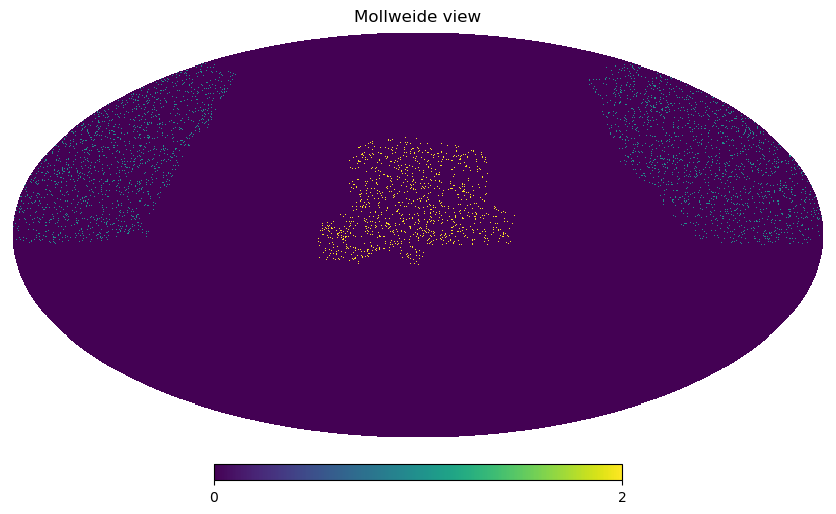

In [4]:
nside = 2048
image = np.zeros(hp.nside2npix(nside))
idx = hp.ang2pix(nside, theta=np.deg2rad(90-galaxy_n['DEC']), phi=np.deg2rad(galaxy_n['RA']))
image[idx] = 1
idx = hp.ang2pix(nside, theta=np.deg2rad(90-galaxy_s['DEC']), phi=np.deg2rad(galaxy_s['RA']))
image[idx] = 2
hp.mollview(image)

used for `polyid`

In [ ]:
def _360_2_180(ra):
    return (ra > 180)*(ra-360) + (ra <= 180)*ra
np.savetxt('../data/SDSSDR12/cmass/cmass-s-ra-dec', np.vstack((galaxy_s['RA'], galaxy_s['DEC'])).T)
np.savetxt('../data/SDSSDR12/cmass/cmass-n-ra-dec', np.vstack((galaxy_n['RA'], galaxy_n['DEC'])).T)

In [21]:
nside = 32
theta, phi = hp.pix2ang(nside=nside, ipix=np.arange(hp.nside2npix(nside)))
np.savetxt('../data/SDSSDR12/cmass/std-ra-dec', np.vstack((phi, np.pi/2-theta)).T)

the rasterized mask

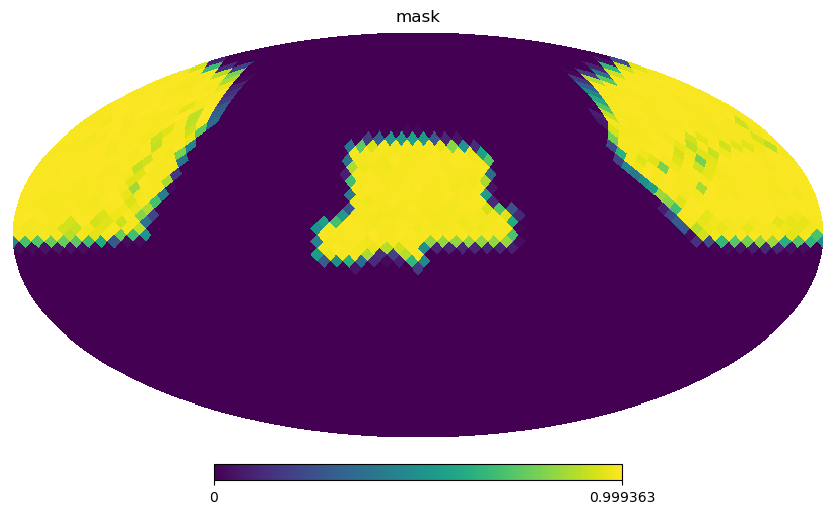

In [13]:
mask_n_pix = np.loadtxt('../data/SDSSDR12/cmass/mask_north_pix', skiprows=1)
mask_s_pix = np.loadtxt('../data/SDSSDR12/cmass/mask_south_pix', skiprows=1)
hp.mollview(mask_s_pix+mask_n_pix, nest=True, title='mask')
weight_rasterized = (mask_s_pix+mask_n_pix)[hp.ang2pix(hp.get_nside(mask_n_pix), theta=np.pi/2-np.deg2rad(galaxy_tot['DEC']), phi=np.deg2rad(galaxy_tot['RA']), nest=True)]

the SDSS mask

In [3]:
import pandas as pd
std_mask_n = pd.read_csv('../data/SDSSDR12/cmass/std-mask-n', sep='\\s+')
std_mask_s = pd.read_csv('../data/SDSSDR12/cmass/std-mask-s', sep='\\s+')
mask_n = fits.getdata('../data/SDSSDR12/cmass/mask_DR12v5_CMASS_North.fits')
mask_s = fits.getdata('../data/SDSSDR12/cmass/mask_DR12v5_CMASS_South.fits')

In [ ]:
id_n = np.array(std_mask_n['polygon_ids'])
id_n[np.isnan(id_n)] = -99
id_n = id_n.astype(int)
weight_n = np.zeros(len(id_n))
weight_n[id_n==-99] = np.nan
weight_n[id_n!=-99] = mask_n['WEIGHT'][id_n[id_n!=-99]]

In [9]:
id_s = np.array(std_mask_s['polygon_ids'])
id_s[np.isnan(id_s)] = -99
id_s = id_s.astype(int)
weight_s = np.zeros(len(id_s))
weight_s[id_s==-99] = np.nan
weight_s[id_s!=-99] = mask_s['WEIGHT'][id_s[id_s!=-99]]

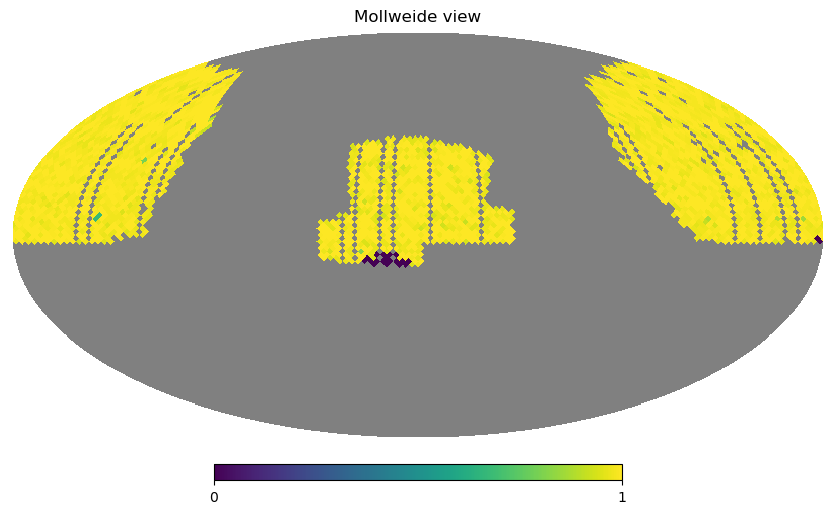

In [12]:
hp.mollview(weight_s+weight_n)

In [10]:
mask_n = fits.getdata('../data/SDSSDR12/cmass/mask_DR12v5_CMASS_North.fits')
mask_s = fits.getdata('../data/SDSSDR12/cmass/mask_DR12v5_CMASS_South.fits')
cmass_polyid_n = np.loadtxt('../data/SDSSDR12/cmass/cmass-n-id', skiprows=1, dtype=[('ra', 'f8'), ('dec', 'f8'), ('id', 'i4')])
cmass_polyid_s = np.loadtxt('../data/SDSSDR12/cmass/cmass-s-id', skiprows=1, dtype=[('ra', 'f8'), ('dec', 'f8'), ('id', 'i4')])
mask_weight_n = mask_n['WEIGHT'][cmass_polyid_n['id']]
mask_weight_s = mask_s['WEIGHT'][cmass_polyid_s['id']]
mask_weight = np.hstack((mask_weight_n, mask_weight_s))

try to add the mask file to the weighting.
There are two kind of weight: generated from `polyid` to see each galaxy's weight, or apply `rasterize` first to get a healpix mask and see the weight.

In [11]:
cmass = np.zeros(len(galaxy_tot), dtype=[('ra', 'f8'), ('dec', 'f8'), ('z', 'f8'), ('w', 'f8')])
cmass['ra'] = galaxy_tot['RA']
cmass['dec'] = galaxy_tot['DEC']
cmass['z'] = galaxy_tot['Z']
cmass['w'] = mask_weight*(galaxy_tot['WEIGHT_NOZ']+galaxy_tot['WEIGHT_CP']-1)
cmass = cmass[np.logical_and(cmass['z']>0.45, cmass['z']<0.7)]
np.save('../catalogue/cmass_z_cut_w1.npy', cmass)

In [14]:
cmass = np.zeros(len(galaxy_tot), dtype=[('ra', 'f8'), ('dec', 'f8'), ('z', 'f8'), ('w', 'f8')])
cmass['ra'] = galaxy_tot['RA']
cmass['dec'] = galaxy_tot['DEC']
cmass['z'] = galaxy_tot['Z']
cmass['w'] = weight_rasterized*(galaxy_tot['WEIGHT_NOZ']+galaxy_tot['WEIGHT_CP']-1)
cmass = cmass[np.logical_and(cmass['z']>0.45, cmass['z']<0.7)]
np.save('../catalogue/cmass_z_cut_w2.npy', cmass)

In [15]:
cmass = np.zeros(len(galaxy_tot), dtype=[('ra', 'f8'), ('dec', 'f8'), ('z', 'f8'), ('w', 'f8')])
cmass['ra'] = galaxy_tot['RA']
cmass['dec'] = galaxy_tot['DEC']
cmass['z'] = galaxy_tot['Z']
cmass['w'] = (galaxy_tot['WEIGHT_NOZ']+galaxy_tot['WEIGHT_CP']-1)
cmass = cmass[np.logical_and(cmass['z']>0.45, cmass['z']<0.7)]
np.save('../catalogue/cmass_z_cut.npy', cmass)

## generate random catalogue

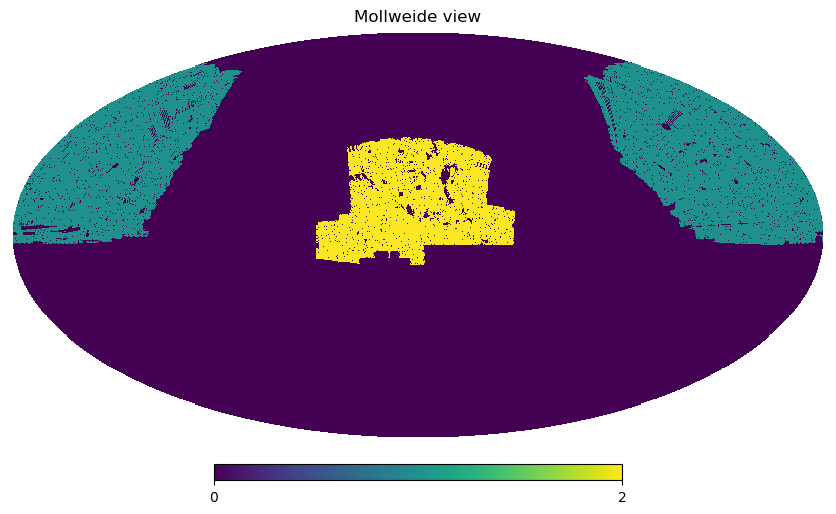

In [16]:
random_n = fits.getdata('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/SDSSDR12/cmass/random0_DR12v5_CMASS_North.fits')
random_s = fits.getdata('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/SDSSDR12/cmass/random0_DR12v5_CMASS_South.fits')
nside = 2048
image = np.zeros(hp.nside2npix(nside))
idx = hp.ang2pix(nside, theta=np.deg2rad(90-random_n['DEC']), phi=np.deg2rad(random_n['RA']))
image[idx] = 1

idx = hp.ang2pix(nside, theta=np.deg2rad(90-random_s['DEC']), phi=np.deg2rad(random_s['RA']))
image[idx] = 2

hp.mollview(image)

In [17]:
random = np.hstack((random_n, random_s))
random_z_cut = random[np.logical_and(random['Z']>0.45, random['Z']<0.7)]
idx = np.random.choice(len(random_z_cut), 7_000_000, replace=False)
random_z_cut = random_z_cut[idx]
ar = np.zeros(len(random_z_cut['RA']), dtype=[('ra', 'f8'), ('dec', 'f8'), ('z', 'f8'), ('w', 'f8')])
ar['ra'] = random_z_cut['RA']
ar['dec'] = random_z_cut['DEC']
ar['z'] = random_z_cut['Z']
ar['w'] = np.ones_like(random_z_cut['Z'])
np.save('../catalogue/cmass_random.npy', ar)